# Commond and Domain-Specific Representations of Moral Wrongness

_Written by Frederic R. Hopp_

In [1]:
import os
# SET WORKDIR
os.chdir('/workspace')

from tools import bootbca_pval

import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pickle

from nltools.data import Brain_Data, Design_Matrix
from nltools.analysis import Roc
from joblib import Parallel, delayed
from sklearn.metrics import root_mean_squared_error
from itertools import combinations
from scipy.stats import ttest_ind,sem,pearsonr, ttest_1samp, bootstrap

import scipy.stats as stats
from sklearn.cross_decomposition import PLSRegression
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
# print sklearn version
import sklearn
print("Using sklearn version:", sklearn.__version__)

Using sklearn version: 1.6.1


In [3]:
betas_brain = Brain_Data('/data/mjs/betas_brain.h5')

model_mapper = {'common':'common',
                'carep':"care_physical",
              'carem':'care_emotional',
              'fair':'fairness',
              'lib':'liberty',
              'loyalty':'loyalty',
              'authority':'authority',
              'sanctity':'sanctity',
              'social_norms':'social_norms'}

type_mapper = {'common':'Common',
                'carep':"Physical Care",
              'carem':'Emotional Care',
              'fair':'Fairness',
              'lib':'Liberty',
              'loyalty':'Loyalty',
              'authority':'Authority',
              'sanctity':'Sanctity',
              'social_norms':'Social Norms'}

cond_mapper = {'care_physical':"Physical Care",
              'care_emotional':'Emotional Care',
              'fairness':'Fairness',
              'liberty':'Liberty',
              'loyalty':'Loyalty',
              'authority':'Authority',
              'sanctity':'Sanctity',
              'social_norms':'Social Norms'}

cond_order = ['care_physical', 'care_emotional', 'fairness', 'liberty', 'loyalty', 'authority', 'sanctity', 'social_norms']

# PLS-R Decoding

In [4]:
betas_dir = '/data/mjs/ucsb_1/'

sub_list = [x.split('/')[-1].split('_')[0] for x in glob.glob(betas_dir+'sub*')]
sub_list.sort()

betas = [x for x in glob.glob(betas_dir+'sub*') if 'cond' in x]
betas.sort()

sub_info = pd.DataFrame()
sub_info['subject'] = pd.Series([x.split('/')[-1].split('_')[0] for x in betas])
sub_info['rating'] = pd.Series([int(x.split('/')[-1].split('c0')[0][-2]) for x in betas])
sub_info['type'] = pd.Series([x.split('/')[-1].split('_')[3:5] for x in betas])
sub_info['type'] = sub_info['type'].apply(lambda x: '_'.join(x)).str.replace('_c0','')
sub_info['type'] = sub_info['type'].str.replace('_1','')
sub_info['type'] = sub_info['type'].str.replace('_2','')
sub_info['type'] = sub_info['type'].str.replace('_3','')
sub_info['type'] = sub_info['type'].str.replace('_4','')

cond_mapper = {'care_physical':"Physical Care",
              'care_emotional':'Emotional Care',
              'fairness':'Fairness',
              'liberty':'Liberty',
              'loyalty':'Loyalty',
              'authority':'Authority',
              'sanctity':'Sanctity',
              'social_norms':'Social Norms'}


# betas_brain = Brain_Data('/data/mjs/betas_brain.h5')

In [ ]:
subjects = sub_info['subject'].unique()
X = np.vstack(betas_brain.data)  # Stack feature arrays into a matrix
# Prepare outcome (Y) data
Y = sub_info.copy()
for k,v in model_mapper.items():
    if v == 'common':
        Y['common'] = Y['rating']
    else:
        for i,row in Y.iterrows():
            if row['type'] == v:
                Y.at[i, v] = row['rating']
            else:
                Y.at[i, v] = 0

del Y['rating']
del Y['type']
del Y['subject']

# predictions = []
# weights = []

# # Leave-One-Subject-Out Cross-Validation with progress bar
# for subject in tqdm(subjects, desc="LOSO-CV Progress"):
#     # Split data into training and testing sets
#     train_idx = sub_info[sub_info['subject'] != subject].index
#     test_idx = sub_info[sub_info['subject'] == subject].index

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

#     # Train PLSRegression model
#     pls = PLSRegression(n_components=20)
#     pls.fit(X_train, y_train)

#     # Predict on the held-out subject
#     y_pred = pls.predict(X_test)

#     # Store predictions and actual values
#     predictions.append(y_pred)
#     weights.append(pls.coef_)

# Create and save weightmaps (not cross-validated) for use in future studies
# pls = PLSRegression(n_components=20)
# pls.fit(X, Y)

# for j, model in enumerate(model_mapper.values()):
#     weight_map = betas_brain[0].copy()
#     weight_map.data = pls.coef_[j]
#     weight_map.save(f'/workspace/pls_weights/{model}_weightmap.nii.gz')
#     break

In [6]:
# # save predictions
# with open('pls/predictions.pkl', 'wb') as f:
#     pickle.dump(predictions, f)

# # save weights
# with open('pls/weights.pkl', 'wb') as f:
#     pickle.dump(weights, f)

In [7]:
weights = pd.read_pickle('pls/weights.pkl')

In [8]:
sub_preds = []
# Cross-Decodings
for i, sub in enumerate(subjects):
    # Get rating info for subject
    sub_rating = sub_info[sub_info['subject'] == sub]
    # Get brain_data for subject
    sub_betas = betas_brain[sub_rating.index]
    # Loop over cross-validated weight maps for subject
    for j, model in enumerate(model_mapper.values()):
        # Get weight map for subject
        cond_weight_map = sub_betas.copy()
        cond_weight_map.data = weights[i][j]
        # Compute pexp for subject
        pexp = sub_betas.similarity(cond_weight_map, method='dot_product') 
        # Store condition-specific pexp in dataframe
        sub_rating[model] = pexp
    # Store subject predictions
    sub_preds.append(sub_rating)

# Concatenate all subject predictions
sub_preds = pd.concat(sub_preds, ignore_index=True)

/tmp/ipykernel_1519713/1755855112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_rating[model] = pexp
/tmp/ipykernel_1519713/1755855112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_rating[model] = pexp
/tmp/ipykernel_1519713/1755855112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [9]:
within_sub_r = sub_preds.groupby(['subject','type'])[list(model_mapper.values())+['rating']].corr()['rating'].reset_index()
within_sub_r = within_sub_r.dropna()
within_sub_r = within_sub_r[within_sub_r['level_2']!='rating']
within_sub_r = within_sub_r.rename(columns={'level_2':'model', 'rating':'correlation'})
within_sub_r_mean = pd.pivot_table(within_sub_r, index='type', columns='model', values='correlation').loc[cond_order]
within_sub_r_mean = within_sub_r_mean[model_mapper.values()]

In [10]:
np.random.seed(0)

within_sub_p = within_sub_r_mean.copy()
for model in within_sub_r_mean.columns:
    for cond in within_sub_r_mean.index:
        corrs = within_sub_r[(within_sub_r['type']==cond) & (within_sub_r['model']==model)]["correlation"]
        stat = corrs.values.mean()
        bstat = bootstrap((corrs,), np.mean, n_resamples=10000).bootstrap_distribution
        p, z = bootbca_pval(0, np.mean, bstat, stat, corrs)
        within_sub_p.loc[cond,model] = p

In [11]:
within_sub_r_mean.round(2)

model,common,care_physical,care_emotional,fairness,liberty,loyalty,authority,sanctity,social_norms
type,,,,,,,,,
care_physical,0.77,0.36,0.16,0.39,0.29,0.06,-0.06,0.22,-0.04
care_emotional,0.81,0.52,0.17,0.38,0.39,0.13,-0.06,0.43,-0.34
fairness,0.90,0.50,0.21,0.62,0.49,0.17,-0.04,0.26,-0.48
liberty,0.90,0.46,0.48,0.47,0.41,-0.32,-0.28,0.29,-0.28
loyalty,0.77,0.24,0.23,0.08,0.23,0.18,0.21,0.27,-0.42
authority,0.85,0.22,0.26,0.27,0.34,0.09,-0.03,0.25,-0.30
sanctity,0.77,0.57,0.10,0.21,0.20,0.11,-0.00,0.43,-0.21
social_norms,0.20,-0.05,0.55,-0.09,0.22,0.09,0.31,0.12,0.03


In [12]:
within_sub_p.round(3)

model,common,care_physical,care_emotional,fairness,liberty,loyalty,authority,sanctity,social_norms
type,,,,,,,,,
care_physical,0.003,0.001,0.114,0.001,0.009,0.570,0.563,0.035,0.670
care_emotional,0.005,0.001,0.099,0.001,0.001,0.235,0.557,0.001,0.000
fairness,0.026,0.001,0.017,0.001,0.001,0.076,0.691,0.006,0.000
liberty,0.011,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001
loyalty,0.003,0.022,0.027,0.401,0.028,0.065,0.049,0.013,0.000
authority,0.006,0.045,0.010,0.013,0.001,0.403,0.783,0.024,0.002
sanctity,0.004,0.001,0.346,0.034,0.037,0.232,0.981,0.001,0.015
social_norms,0.224,0.690,0.003,0.629,0.204,0.611,0.054,0.491,0.869


<Axes: xlabel='type', ylabel='model'>

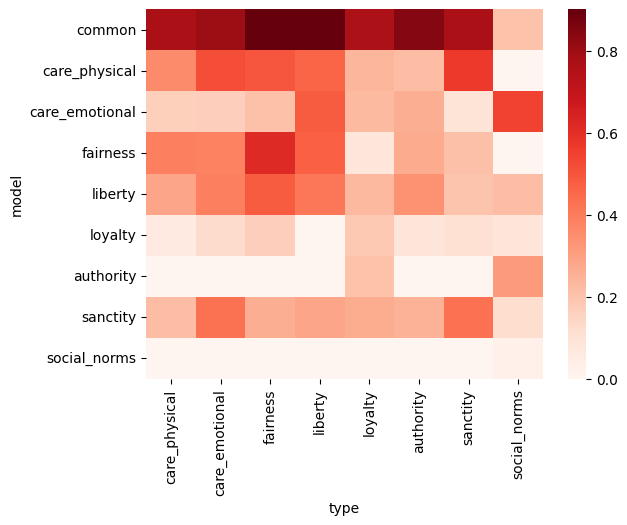

In [13]:
sns.heatmap(within_sub_r_mean.T, cmap='Reds', vmin=0)

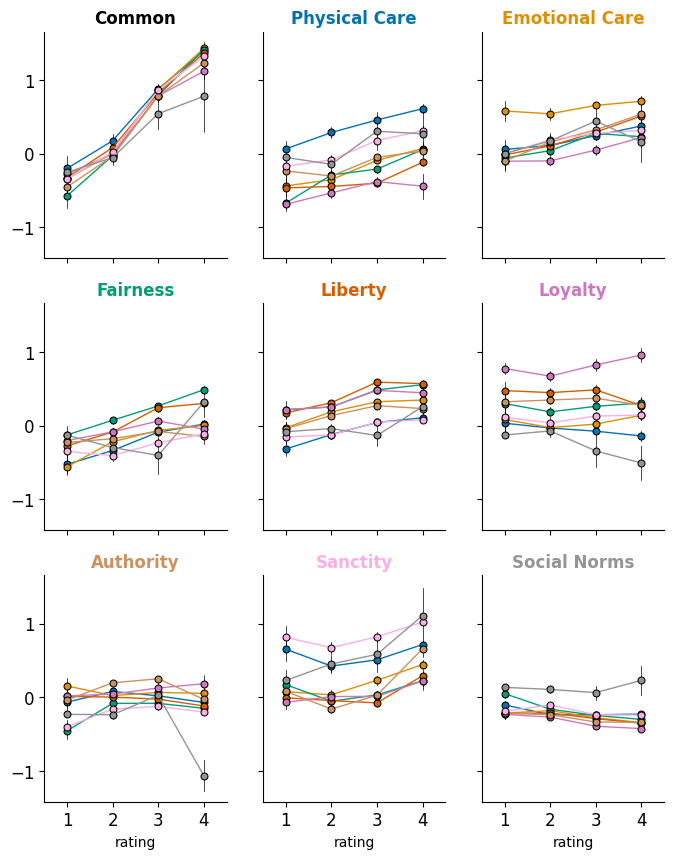

In [14]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k
    return None

fig, ax = plt.subplots(3, 3, figsize=(8, 10), sharex=True, sharey=True)
for i, model in enumerate(model_mapper.values()):
    sns.pointplot(x='rating', y=model, data=sub_preds, hue='type', ax = ax.flatten()[i], legend=False,
                  errorbar='se', err_kws={'color':"black", 'linewidth': 1, "zorder":-1, 'linewidth':0.5}, hue_order=cond_order, palette='colorblind', **{'linewidth':1, 'markersize':5, 'markeredgecolor':'black'})
    if i == 0:
        ax.flatten()[i].set_title(type_mapper[get_key(model_mapper, model)], weight='bold')
    else:
        ax.flatten()[i].set_title(type_mapper[get_key(model_mapper, model)], weight='bold', color=sns.color_palette('colorblind', 9)[i-1])
    # change font size for x and y ticks
    ax.flatten()[i].tick_params(axis='both', which='major', labelsize=12)
    sns.despine()
    # remove ylabel
    ax.flatten()[i].set_ylabel('')

# plt.savefig('plots/cross_model_comparisons.png', dpi=300, bbox_inches='tight')

<Axes: xlabel='type'>

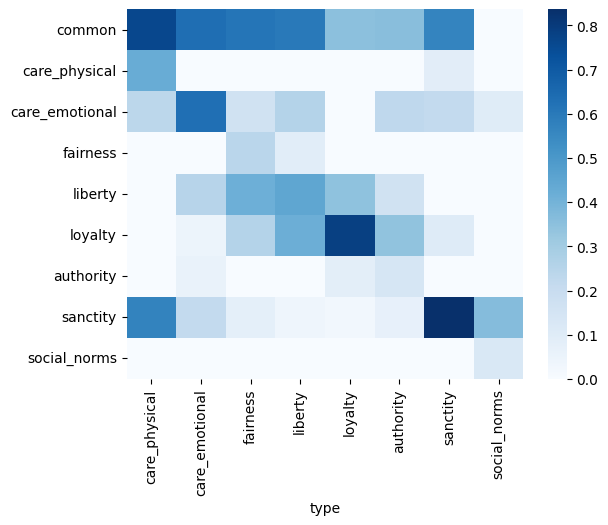

In [15]:
cond_mean_pred = sub_preds.groupby(['type'])[list(model_mapper.values())].mean().loc[cond_order]
sns.heatmap(cond_mean_pred.T, cmap='Blues', vmin=0)

In [16]:
cond_mean_pred.T.round(2)

type,care_physical,care_emotional,fairness,liberty,loyalty,authority,sanctity,social_norms
common,0.76,0.64,0.61,0.60,0.35,0.36,0.57,-0.08
care_physical,0.43,-0.16,-0.20,-0.34,-0.51,-0.15,0.09,-0.03
care_emotional,0.24,0.63,0.17,0.26,-0.00,0.23,0.22,0.10
fairness,-0.16,-0.15,0.24,0.09,-0.06,-0.15,-0.27,-0.18
liberty,-0.01,0.25,0.41,0.45,0.34,0.16,-0.02,-0.06
loyalty,-0.08,0.05,0.26,0.42,0.79,0.34,0.11,-0.15
authority,-0.00,0.06,-0.14,-0.04,0.09,0.14,-0.20,-0.25
sanctity,0.57,0.22,0.08,0.04,0.03,0.07,0.84,0.36
social_norms,-0.22,-0.26,-0.21,-0.28,-0.32,-0.28,-0.19,0.13


In [17]:
# t-test comparing average pattern expression across conditions for each model
for model in model_mapper.values(): 
    model_data = sub_preds[['rating', 'type', model]].dropna()
    print('Model:', model)
    if model == 'common':
        for cond_pair in combinations(cond_order, 2):
            print(cond_pair)
            t, p = ttest_ind(model_data[model_data['type']==cond_pair[0]][model], model_data[model_data['type']==cond_pair[1]][model])
            print(round(t, 2), round(p*7, 4))

    else:    
        for cond in cond_order:
            print(cond)
            t, p = ttest_ind(model_data[model_data['type']==model_mapper[get_key(model_mapper, model)]][model], model_data[model_data['type']==cond][model])
            print(round(t, 2), round(p*7, 5))

    print('\n')

Model: common
('care_physical', 'care_emotional')
1.46 1.0118
('care_physical', 'fairness')
1.73 0.5943
('care_physical', 'liberty')
1.91 0.3964
('care_physical', 'loyalty')
4.95 0.0
('care_physical', 'authority')
4.66 0.0
('care_physical', 'sanctity')
2.27 0.168
('care_physical', 'social_norms')
9.22 0.0
('care_emotional', 'fairness')
0.27 5.5034
('care_emotional', 'liberty')
0.4 4.8297
('care_emotional', 'loyalty')
3.3 0.0074
('care_emotional', 'authority')
3.08 0.0156
('care_emotional', 'sanctity')
0.78 3.0546
('care_emotional', 'social_norms')
7.39 0.0
('fairness', 'liberty')
0.12 6.3453
('fairness', 'loyalty')
2.98 0.0213
('fairness', 'authority')
2.78 0.0402
('fairness', 'sanctity')
0.5 4.3164
('fairness', 'social_norms')
6.99 0.0
('liberty', 'loyalty')
2.97 0.0223
('liberty', 'authority')
2.76 0.0426
('liberty', 'sanctity')
0.4 4.8333
('liberty', 'social_norms')
7.21 0.0
('loyalty', 'authority')
-0.11 6.4129
('loyalty', 'sanctity')
-2.49 0.0922
('loyalty', 'social_norms')
4.72 0